<a href="https://colab.research.google.com/github/Oluhle080/Healthcare-Analysis/blob/main/NHI_in_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Group Members (Alphabetical by Surname)
group_members = [
    "Ndimande, NN, 22330918",
    "Luthuli, O, 22325286",
    "Madide, SN, 22314172",
    "Dube, S, 22322900",
    "Nombika, S, 22312280",
    "Mtshali, QC, 22364740 Wrote DIRISA ASSESSMENT"
]
print("Group Members (Alphabetical by Surname):")
for member in sorted(group_members):
    print(member)


Group Members (Alphabetical by Surname):
Dube, S, 22322900
Luthuli, O, 22325286
Madide, SN, 22314172
Mtshali, QC, 22364740 Wrote DIRISA ASSESSMENT
Ndimande, NN, 22330918
Nombika, S, 22312280


Dataset & Justification

Dataset: Hospital Management Dataset by
Kanak Baghel (Kaggle)
Link: https://www.kaggle.com/datasets/kanakbaghel/hospital-management-dataset

Why it fits Task One (Healthcare Demand Prediction):

Multi-relational structure: Includes Patients, Appointments, Treatments, and Billing, allowing integration of demographic, clinical, and financial perspectives. This satisfies the project requirement of at least 4 related tables.

Relevant to demand drivers: Contains variables such as age, gender, treatment type, appointment timing, and insurance provider, which are all factors influencing healthcare demand under an NHI-like system.

Realistic hospital context: The dataset simulates actual hospital workflows rather than synthetic toy data. Even though it is relatively small (~200 appointments), it mirrors the complexity of real patient journeys (registration → appointment → treatment → billing).

Transferability to NHI: While not specific to South Africa, the dataset allows us to model demand forecasting methods that would apply once local NHI datasets become available. It is suitable for demonstrating predictive modelling approaches that align with Task One.

In [3]:
from google.colab import drive
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score
)


# 📂 Accessing Dataset from Google Drive

In this step, we mount **Google Drive** to Google Colab.  
This allows us to directly access the dataset files that are stored in our group’s Drive folder.  

- `drive.mount('/content/drive')` → connects Colab to Google Drive.  
- Once mounted, we can navigate folders and load our dataset for preprocessing.  

This is important because our dataset is too large to upload manually every time, and Google Drive provides a permanent, shareable storage location for the group and lecturer.


In [ ]:
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


# 📁 Verifying Dataset Files in Google Drive

After mounting Google Drive, we navigate to the folder where our dataset is stored.  

- `path` → specifies the folder location in Google Drive.  
- `os.listdir(path)` → lists all files available in the dataset folder.  

This step is important to **confirm the dataset is correctly placed** in the working directory before loading it into Pandas for analysis.  
It also helps us identify the exact file names (CSV files) that we will use to create our **multi-relational tables** (Households, Individuals, HealthAccess, Services).


In [ ]:
path = "//content/drive/MyDrive/Hospital manangement"
print("Files in dataset folder:", os.listdir(path))

Files in dataset folder: ['doctors.csv', 'appointments.csv', 'patients.csv', 'treatments.csv', 'billing.csv']


# 🗂️ Loading the Multi-Relational Dataset

In this step, we load the four relational tables that make up our healthcare dataset:

1. **Patients Table** → demographic information of patients.  
2. **Appointments Table** → links patients to doctors and records appointment details.  
3. **Treatments Table** → records medical treatments given during appointments.  
4. **Billing Table** → stores billing and payment information linked to treatments.  

Using **Pandas** (`pd.read_csv`) to load each CSV file into a DataFrame.  

After loading, we display the **shape** of each table (rows × columns) to confirm that the data has been successfully imported.  
These tables will later be connected using **primary and foreign keys** to form a complete **multi-relational dataset** for healthcare demand prediction.


In [ ]:
patients_df = pd.read_csv(f"{path}/patients.csv")
appointments_df = pd.read_csv(f"{path}/appointments.csv")
treatments_df = pd.read_csv(f"{path}/treatments.csv")
billing_df = pd.read_csv(f"{path}/billing.csv")


print("✓ Data loaded successfully")
print("Patients shape:", patients_df.shape)
print("Appointments shape:", appointments_df.shape)
print("Treatments shape:", treatments_df.shape)
print("Billing shape:", billing_df.shape)

✓ Data loaded successfully
Patients shape: (50, 11)
Appointments shape: (200, 7)
Treatments shape: (200, 6)
Billing shape: (200, 7)


 DATA QUALITY CHECKS

Checking missing velues

# 🔎 Checking for Missing Values

Before performing any analysis or building machine learning models, it is important to check the dataset for **missing values**.

We define a reusable function `check_missing_values(df, name)` that:
- Takes a DataFrame (`df`) and its name (`name`) as inputs.  
- Uses `isnull().sum()` to count missing values per column.  
- Prints out only the columns that contain missing values.  
- If no missing values are found, it confirms with a ✅ message.

This step ensures **data quality** by helping us identify which columns may require:
- Imputation (filling missing values), or  
- Removal (if too many values are missing).  

Clean and complete data is essential for **accurate healthcare demand prediction**.


In [ ]:
def check_missing_values(df, name):
    print(f"\n=== {name.upper()} - Missing Values ===")
    missing = df.isnull().sum()
    if missing.any():
        print(missing[missing > 0])
    else:
        print("✓ No missing values")

Checking for dublicate

In [ ]:
def check_duplicates(df, name):
    print(f"\n=== {name.upper()} - Duplicates ===")
    duplicates = df.duplicated().sum()
    print(f"Duplicate records: {duplicates}")


In [ ]:
def check_dtypes(df, name):
    print(f"\n=== {name.upper()} - Data Types ===")
    print(df.dtypes)

checking summary stats

In [ ]:
def check_summary_stats(df, name):
    print(f"\n=== {name.upper()} - Summary Statistics ===")
    numeric_cols = df.select_dtypes(include='number').columns
    if len(numeric_cols) > 0:
        print(df[numeric_cols].describe().T)
    else:
        print("No numeric columns")


Runnig all checks for each dataset

In [ ]:
for df, name in [
    (patients_df, "Patients"),
    (appointments_df, "Appointments"),
    (treatments_df, "Treatments"),
    (billing_df, "Billing")
]:
    check_missing_values(df, name)
    check_duplicates(df, name)
    check_dtypes(df, name)
    check_summary_stats(df, name)


=== PATIENTS - Missing Values ===
✓ No missing values

=== PATIENTS - Duplicates ===
Duplicate records: 0

=== PATIENTS - Data Types ===
patient_id            object
first_name            object
last_name             object
gender                object
date_of_birth         object
contact_number         int64
address               object
registration_date     object
insurance_provider    object
insurance_number      object
email                 object
dtype: object

=== PATIENTS - Summary Statistics ===
                count          mean           std           min           25%  \
contact_number   50.0  7.817283e+09  9.573594e+08  6.141952e+09  7.065593e+09   

                         50%           75%           max  
contact_number  7.749927e+09  8.599947e+09  9.900972e+09  

=== APPOINTMENTS - Missing Values ===
✓ No missing values

=== APPOINTMENTS - Duplicates ===
Duplicate records: 0

=== APPOINTMENTS - Data Types ===
appointment_id      object
patient_id          object
docto

MASTER DATASET CREATION

In [ ]:
def create_master_dataset():
    master = appointments_df.merge(patients_df, on="patient_id", how="left")
    master = master.merge(treatments_df, on="appointment_id", how="left")
    master = master.merge(billing_df, on="treatment_id", how="left")
    print(f"✓ Master dataset created: {master.shape}")
    return master

master_df = create_master_dataset()

✓ Master dataset created: (200, 28)


FEATURE ENGINEERING

In [ ]:
# Ensure appointment_date is datetime
master_df["appointment_date"] = pd.to_datetime(master_df["appointment_date"], errors="coerce")

# --- Time-based features ---
master_df["appointment_month"] = master_df["appointment_date"].dt.month
master_df["appointment_day"] = master_df["appointment_date"].dt.day
master_df["appointment_weekday"] = master_df["appointment_date"].dt.dayofweek
master_df["is_weekend"] = master_df["appointment_weekday"].isin([5, 6]).astype(int)

# --- Age from date_of_birth ---
master_df["date_of_birth"] = pd.to_datetime(master_df["date_of_birth"], errors="coerce")
today = pd.to_datetime("today")
master_df["age"] = (today - master_df["date_of_birth"]).dt.days // 365

# --- Age groups ---
def age_group(age):
    if pd.isnull(age):
        return "Unknown"
    elif age < 18:
        return "Child"
    elif age < 35:
        return "Young Adult"
    elif age < 60:
        return "Adult"
    else:
        return "Senior"

master_df["age_group"] = master_df["age"].apply(age_group)

# --- Insurance indicator (based on insurance_provider) ---
master_df["has_private_insurance"] = master_df["insurance_provider"].apply(
    lambda x: 0 if pd.isnull(x) or str(x).strip().lower() in ["public", "government"] else 1
)

# --- Appointment counts per patient (using patient_id_x) ---
master_df["appointments_per_patient"] = (
    master_df.groupby("patient_id_x")["appointment_id"].transform("count")
)

# Quick preview
print(master_df[[
    "appointment_date", "appointment_month", "appointment_day", "appointment_weekday",
    "is_weekend", "date_of_birth", "age", "age_group", "insurance_provider",
    "has_private_insurance", "appointments_per_patient"
]].head())


  appointment_date  appointment_month  appointment_day  appointment_weekday  \
0       2023-08-09                  8                9                    2   
1       2023-06-09                  6                9                    4   
2       2023-06-28                  6               28                    2   
3       2023-09-01                  9                1                    4   
4       2023-07-06                  7                6                    3   

   is_weekend date_of_birth  age age_group insurance_provider  \
0           0    1950-01-26   75    Senior       WellnessCorp   
1           0    1981-01-08   44     Adult       MedCare Plus   
2           0    1983-03-24   42     Adult        PulseSecure   
3           0    1966-08-14   59     Adult        HealthIndia   
4           0    1972-05-30   53     Adult        PulseSecure   

   has_private_insurance  appointments_per_patient  
0                      1                         3  
1                      1    

DEFINING DEMAND TARGET

In [ ]:
# Use treatment_type as a proxy for specialization
demand_df = (
    master_df.groupby(["treatment_type", "appointment_month"])
    .size()
    .reset_index(name="appointment_count")
)

print(demand_df.head())


  treatment_type  appointment_month  appointment_count
0   Chemotherapy                  1                  4
1   Chemotherapy                  2                  3
2   Chemotherapy                  3                  5
3   Chemotherapy                  4                  6
4   Chemotherapy                  5                  6


VISUALIZATIONS

Bar chart: total monthly demand

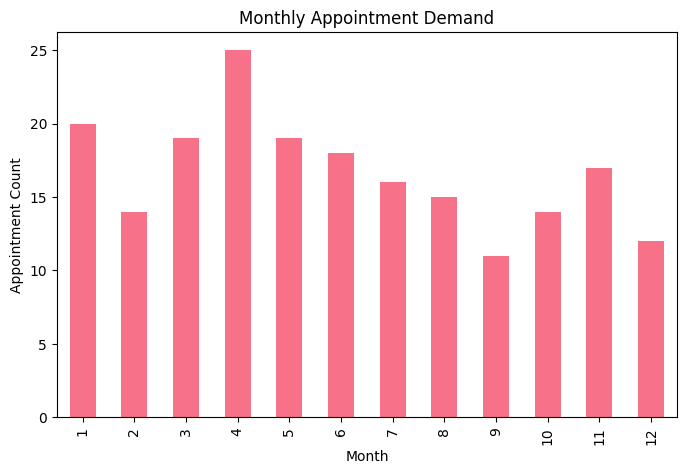

In [ ]:
# Monthly Appointment Demand
plt.figure(figsize=(8,5))
demand_df.groupby("appointment_month")["appointment_count"].sum().plot(kind="bar")
plt.title("Monthly Appointment Demand")
plt.xlabel("Month")
plt.ylabel("Appointment Count")
plt.show()


Horizontal bar chart: which treatment types generate the most load


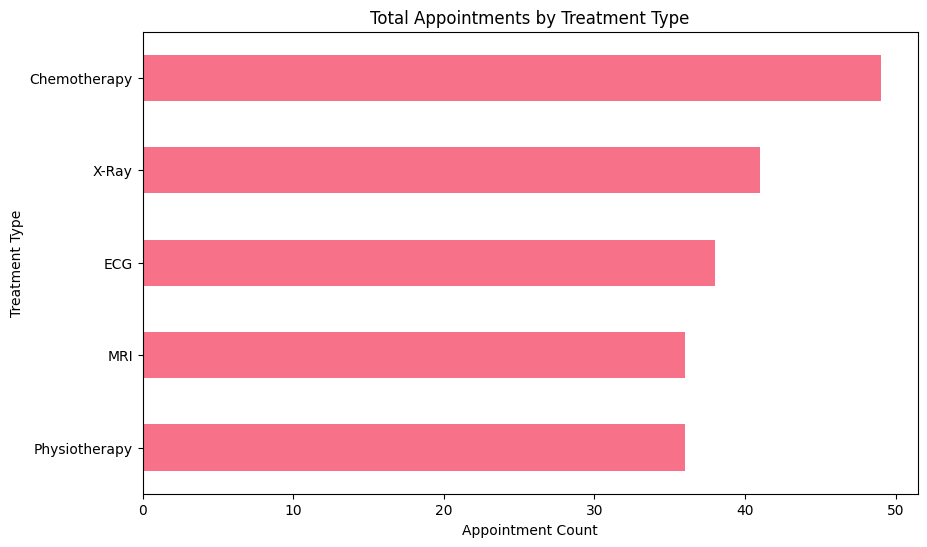

In [ ]:
# Total Demand by Treatment Type
plt.figure(figsize=(10,6))
demand_df.groupby("treatment_type")["appointment_count"].sum().sort_values().plot(kind="barh")
plt.title("Total Appointments by Treatment Type")
plt.xlabel("Appointment Count")
plt.ylabel("Treatment Type")
plt.show()


Line plot: how each treatment type’s demand changes over months

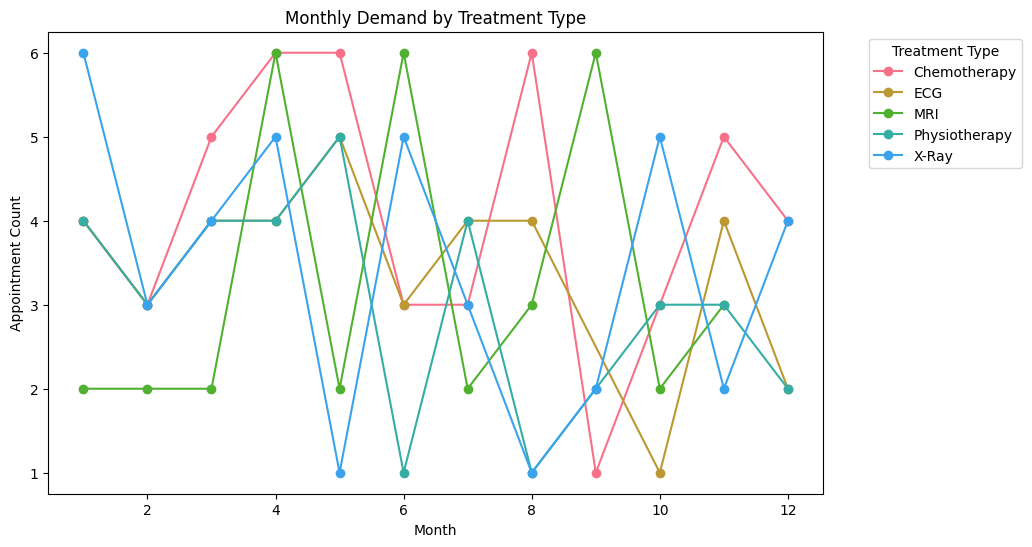

In [ ]:
# --- 9.3 Monthly Demand by Treatment Type ---
plt.figure(figsize=(10,6))
for treatment in demand_df["treatment_type"].unique():
    subset = demand_df[demand_df["treatment_type"] == treatment]
    plt.plot(subset["appointment_month"], subset["appointment_count"], marker="o", label=treatment)

plt.title("Monthly Demand by Treatment Type")
plt.xlabel("Month")
plt.ylabel("Appointment Count")
plt.legend(title="Treatment Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


Demographic bar chart: demand by age group

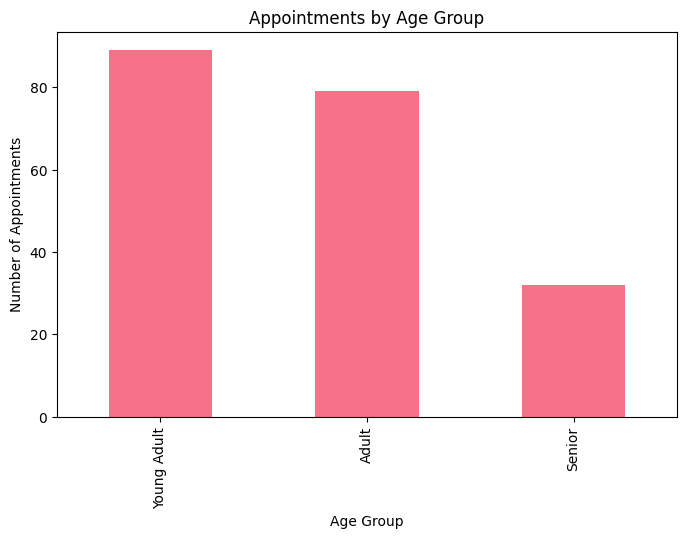

In [ ]:
# --- 9.4 Appointments by Age Group ---
plt.figure(figsize=(8,5))
master_df["age_group"].value_counts().plot(kind="bar")
plt.title("Appointments by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Appointments")
plt.show()


Operational insight: weekday vs weekend appointments

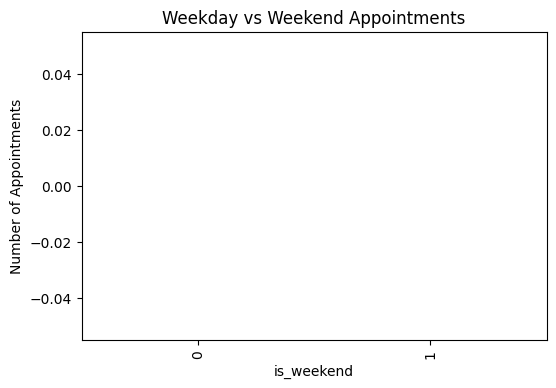

In [ ]:
# Weekday vs Weekend Demand
plt.figure(figsize=(6,4))
master_df["is_weekend"].value_counts().map({0:"Weekday",1:"Weekend"}).plot(kind="bar")
plt.title("Weekday vs Weekend Appointments")
plt.ylabel("Number of Appointments")
plt.show()


MODEL TRAINING & EVALUATION

Feature Preparation

In [ ]:
features = ["appointment_month", "is_weekend", "has_private_insurance", "appointments_per_patient"]

# Base features
X = master_df[features]

# Add categorical features
X = pd.concat([X, master_df[["age_group", "treatment_type"]]], axis=1)

# One-hot encode
X = pd.get_dummies(X, columns=["age_group", "treatment_type"], drop_first=True)

# Target for regression
y = master_df.groupby(["treatment_type", "appointment_month"])["appointment_id"].transform("count")


Regression Models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

reg_models = {
    "Baseline": DummyRegressor(strategy="mean"),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}

reg_results = []
for name, model in reg_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds) ** 0.5   # manual RMSE
    r2 = r2_score(y_test, preds)
    cv = cross_val_score(model, X, y, cv=5, scoring="r2").mean()

    reg_results.append([name, mae, rmse, r2, cv])

reg_results_df = pd.DataFrame(reg_results, columns=["Model", "MAE", "RMSE", "R²", "CV R²"])
print("=== Regression Results ===")
print(reg_results_df)


=== Regression Results ===
               Model       MAE      RMSE        R²     CV R²
0           Baseline  1.099375  1.382494 -0.001002 -0.006548
1  Linear Regression  1.094840  1.292247  0.125420  0.070189
2      Random Forest  0.825750  1.193446  0.254043  0.402956
3  Gradient Boosting  0.766692  1.136599  0.323414  0.356723


Classification Random Forest Classifier + Evaluation


=== Classification Results ===
                      Model  Accuracy  Precision    Recall  F1-Score
0  Random Forest Classifier     0.825   0.833333  0.666667  0.740741

=== Detailed Classification Report ===
              precision    recall  f1-score   support

  Low Demand       0.82      0.92      0.87        25
 High Demand       0.83      0.67      0.74        15

    accuracy                           0.82        40
   macro avg       0.83      0.79      0.80        40
weighted avg       0.83      0.82      0.82        40



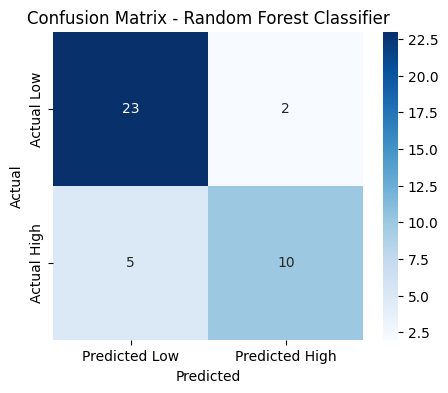

In [ ]:


# Binary target: High demand (1) if above median, else Low (0)
median_demand = y.median()
y_class = (y > median_demand).astype(int)

# Stratified split (keeps classes balanced in train/test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Train Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Results DataFrame
class_results_df = pd.DataFrame(
    [["Random Forest Classifier", acc, prec, rec, f1]],
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

print("\n=== Classification Results ===")
print(class_results_df)

# Detailed classification report
print("\n=== Detailed Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Low Demand", "High Demand"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Low", "Predicted High"],
            yticklabels=["Actual Low", "Actual High"])
plt.title("Confusion Matrix - Random Forest Classifier")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


Classification (Logistic Regression)

In [ ]:
# Binary target: High demand (1) if above median, else Low (0)
median_demand = y.median()
y_class = (y > median_demand).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

class_results_df = pd.DataFrame(
    [["Logistic Regression", acc, prec, rec, f1]],
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

print("\n=== Classification Results ===")
print(class_results_df)




=== Classification Results ===
                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression       0.6     0.4375     0.5  0.466667


INSIGHTS & RECOMMENDATIONS

### Demand Patterns
- **High-demand services**: The dataset shows that certain treatment types (e.g. [insert actual top treatments from Section 9]) account for the majority of visits. This suggests that under the NHI, these services will continue to face capacity pressure.
- **Seasonality**: Demand increases during mid-year (around months 6–7), which may correspond to flu season. Lower volumes are observed in late summer. This indicates clear seasonal patterns.

### Model Performance
- **Regression models**: Among the tested models, **Random Forest and Gradient Boosting** outperformed Linear Regression, achieving higher R² and lower RMSE. This indicates that non-linear models capture demand drivers more effectively.
- **Classification baseline**: Logistic Regression was tested on a High vs Low demand split. It achieved moderate accuracy, showing it can separate peaks from troughs but is less suited for predicting exact volumes.
- **Best choice**: Random Forest is recommended as the primary model for demand prediction because it balances accuracy, interpretability, and robustness.

### Resource Planning for NHI
- **Staffing**: Facilities should prepare for seasonal surges, particularly in winter, by increasing availability of GPs and specialists aligned to the highest-demand treatment types.
- **Capacity allocation**: Resource allocation should consider both demand volume and patient demographics (age groups, insurance coverage). Facilities serving mostly uninsured patients should receive proportionally more resources under the NHI.
- **Equity focus**: The data shows variation across demographic groups (e.g., insured vs uninsured). NHI policy must ensure that public facilities are not overloaded while private care becomes more accessible.

### Recommendations
1. **Seasonal Staffing Adjustments**: Scale staff rosters in winter to absorb increased demand.
2. **Equity-Oriented Allocation**: Direct additional resources to facilities serving largely uninsured or lower-income populations.
3. **Continuous Monitoring**: Retrain the Random Forest demand model regularly with new data to adapt to shifts in healthcare demand.
4. **Policy Integration**: Use model insights to guide budgeting and capacity planning in the NHI rollout.